# T5 Fine Tuning on Custom Chatbot Dataset

Data-to-Text Conditional Generation \
System Response Text Generation

---


**Practice Module: Practical Language Processing (PLP)**

**Group: 17**

Members:

`Lim Jun Ming`, `A0231523U`

`Tadhg Kennedy`, 

`Gopan Ravikumar Girija`,

# 0. Initialization

## Install necessary modules

In [1]:
# !pip install -U transformers

In [2]:
# !pip install sentencepiece

In [3]:
# !pip install datasets

In [4]:
# !pip install sacrebleu

In [5]:
# !pip install torchinfo

## Imports

In [6]:
import os
# from google.colab import drive

import numpy as np
import pandas as pd
import json
import random
import time
import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import datasets

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler


## Mounting Drive

In [7]:
# # Mounting to Google Driveg
# drive.mount('/content/gdrive')

# # Change Working Directory
# os.chdir('/content/gdrive/My Drive/iss/plp_pm/')

## Pytorch Setup

In [8]:
# Print Torch version
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print('-' * 10)

# Check GPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1.10.1+cu113
11.3
8200
----------
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [9]:
seed=17

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()



In [10]:
!nvidia-smi

Tue Apr 12 01:23:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 18%   59C    P0    50W / 400W |   2816MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## File Paths

In [11]:
basedir = os.getcwd()
datadir = os.path.join(basedir, 'Data')
print(basedir)
print(datadir)



D:\Personal\Education\NUS-ISS Mtech IS\Course Materials\4. Practical Language Processing (PLP)\0. PLP Project\Code\NLG
D:\Personal\Education\NUS-ISS Mtech IS\Course Materials\4. Practical Language Processing (PLP)\0. PLP Project\Code\NLG\Data


# 1. Data Preparation

## >> DATA PARAMETERS

In [12]:
# Data Parameters

BATCH_SIZE = 64
MAX_LENGTH = 64 # With some buffer given the longest input number of token = 28
MODEL_NAME = 't5-small'

## Load Data

In [13]:
# Read Data File

data_path = os.path.join(datadir, 'Custom_Dataset')
data_path = os.path.join(data_path, 'SYSTEM_NLG_Custom_Dataset_Clean.xlsx')

df = pd.read_excel(data_path, index_col=0)

print('Number of data points :', len(df))
print('-'* 50)
print(df.info())
df.head()

Number of data points : 1030
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 0 to 1029
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Code      1030 non-null   object
 1   Text      1030 non-null   object
 2   Type      1030 non-null   object
 3   Sub-Type  1030 non-null   object
dtypes: object(4)
memory usage: 40.2+ KB
None


,Code,Text,Type,Sub-Type
0,MOVIE_RECOMMEND REQUEST ( genre = ? ; directed...,"Do you have any preference on the movie genre,...",MOVIE_RECOMMEND REQUEST,MOVIE_RECOMMEND REQUEST
1,MOVIE_RECOMMEND REQUEST ( genre = ? ; directed...,"Any preference on the genre, directors or acto...",MOVIE_RECOMMEND REQUEST,MOVIE_RECOMMEND REQUEST
2,MOVIE_RECOMMEND REQUEST ( genre = ? ; directed...,What kind of movie do you like? Any movie genr...,MOVIE_RECOMMEND REQUEST,MOVIE_RECOMMEND REQUEST
3,MOVIE_RECOMMEND REQUEST ( genre = ? ; directed...,"Any movie genre, directors or actors you have ...",MOVIE_RECOMMEND REQUEST,MOVIE_RECOMMEND REQUEST
4,MOVIE_RECOMMEND REQUEST ( genre = ? ; directed...,What type of movie do you like? Any movie genr...,MOVIE_RECOMMEND REQUEST,MOVIE_RECOMMEND REQUEST


In [14]:
# Data Code and Data Text

df_code = df['Code']
df_text = df['Text']
data_df = df[['Code', 'Text']]
# Code Type and Sub-type (for stratify train-test split)

df_type = df['Type']
df_subtype = df['Sub-Type']

print('Distribution by Type')
print('-' * 70)
print(df_type.value_counts())
print('=' * 100)
print('Distribution by Sub-type')
print('-' * 70)
print(df_subtype.value_counts())


Distribution by Type
----------------------------------------------------------------------
MOVIE_RECOMMEND NOTIFY_SEARCHING    160
MOVIE_RECOMMEND NOTIFY_SUCCESS      160
MOVIE_RECOMMEND NOTIFY_FAILURE      160
MOVIE_RECOMMEND REQUEST             100
MOVIE_SENTIMENT REQUEST             100
MOVIE_SENTIMENT NOTIFY_SEARCHING     50
MOVIE_SENTIMENT NOTIFY_SUCCESS       50
MOVIE_SENTIMENT NOTIFY_FAILURE       50
MOVIE_RECOMMEND REQ_MORE             50
MOVIE_SENTIMENT REQ_MORE             50
MOVIE_RECOMMEND GOODBYE              50
MOVIE_SENTIMENT GOODBYE              50
Name: Type, dtype: int64
Distribution by Sub-type
----------------------------------------------------------------------
MOVIE_RECOMMEND REQUEST                                  100
MOVIE_SENTIMENT REQUEST                                  100
MOVIE_SENTIMENT NOTIFY_SEARCHING                          50
MOVIE_RECOMMEND GOODBYE                                   50
MOVIE_SENTIMENT REQ_MORE                                  50
MO

In [15]:
# Quick check for token length

code_len = np.array([len(x.split(' ')) for x in df_code])
text_len = np.array([len(x.split(' ')) for x in df_text])

print('Longest tokens of Control Code :', code_len.max())
print('Shorted tokens of Control Code :', code_len.min())
print('Longest tokens of Target Text  :', text_len.max())
print('Shorted tokens of Target Text  :', text_len.min())

Longest tokens of Control Code : 18
Shorted tokens of Control Code : 2
Longest tokens of Target Text  : 26
Shorted tokens of Target Text  : 2


## Train-Val Split

For Fine-Tuning on custom dataset

In [16]:
# Train-Val Split
idx = range(len(data_df))
stratify_label = df_type

VAL_RATIO = 0.2

train_idx, val_idx, _, _ = train_test_split(idx, stratify_label, stratify=stratify_label, test_size=VAL_RATIO, random_state=seed)

data_train_df = data_df.iloc[train_idx, :].reset_index(drop=True)
data_val_df = data_df.iloc[val_idx, :].reset_index(drop=True)

print('Number of training samples   :', len(data_train_df))
print('Number of validation samples :', len(data_val_df))

Number of training samples   : 824
Number of validation samples : 206


## Load T5 Tokenizer

In [17]:
# Initialize GPT2 Tokenizer from HuggingFace-Transformer

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
# num_special_tokens = tokenizer.add_special_tokens(SPECIAL_TOKENS)
print(f'Special Tokens Added, vocab size = {len(tokenizer)}')

Special Tokens Added, vocab size = 32100


In [18]:
# Test Tokenizer

sample_id = 625
try_code = df_code[sample_id]
try_text = df_text[sample_id]
test_tokenized = tokenizer(try_text, 
                           padding='max_length', 
                           max_length=MAX_LENGTH, 
                           truncation=True, 
                           return_attention_mask = True,
                           return_tensors = 'pt')
print('-' * 100)
print('Original Text:')
print('-' * 100)
print(try_code)
print(try_text)
print('')
print('-' * 100)
print('Tokenization Outputs:')
print('-' * 100)
print(test_tokenized)
print('Decoded Text:')
print('-' * 100)
print(tokenizer.decode(token_ids=test_tokenized['input_ids'][0]))

----------------------------------------------------------------------------------------------------
Original Text:
----------------------------------------------------------------------------------------------------
MOVIE_RECOMMEND NOTIFY_FAILURE ( genre = comedy )
Sorry, but I wasn't able to find any match for comedy films

----------------------------------------------------------------------------------------------------
Tokenization Outputs:
----------------------------------------------------------------------------------------------------
{'input_ids': tensor([[11342,     6,    68,    27,  2088,    31,    17,     3,   179,    12,
           253,   136,  1588,    21, 12373,  4852,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## Pytorch Dataset

In [19]:
# Pytorch Dataset
# >> Encodes original text with GPT2 Tokenizer
# >> The control code and target utterance are structured into the following form:
# >> [BOS] CONTROL_CODE [SEP] TARGET_UTTERANCE [EOS]


class TOD_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, process_length):

        self.input_code = data['Code']
        self.output_target = data['Text']

        # Tokenizer Input_code
        self.input_tokenized = tokenizer.batch_encode_plus(self.input_code,
                                                           padding='max_length',
                                                           max_length=process_length,
                                                           truncation=True, 
                                                           return_attention_mask = True, 
                                                           return_tensors = 'pt')

        self.input_ids = self.input_tokenized['input_ids']
        self.input_attn = self.input_tokenized['attention_mask']

        # Tokenizer Input_code
        self.target_tokenized = tokenizer.batch_encode_plus(self.output_target,
                                                            padding='max_length',
                                                            max_length=process_length,
                                                            truncation=True, 
                                                            return_attention_mask = True, 
                                                            return_tensors = 'pt')

        self.target_ids = self.target_tokenized['input_ids']
        self.target_ids[self.target_ids == tokenizer.pad_token_id] = -100


    def __len__(self):
        return len(self.input_code)

    def __getitem__(self, idx):
        input_ids   = self.input_ids[idx]
        input_mask  = self.input_attn[idx]
        target_ids  = self.target_ids[idx]

        return input_ids, input_mask, target_ids

## Dataset & Dataloader

In [20]:
# # Create Dataset
# st = time.time()

# train_dataset = TOD_Dataset(train_df, tokenizer, MAX_LENGTH)
# val_dataset = TOD_Dataset(val_df, tokenizer, MAX_LENGTH)
# test_dataset = TOD_Dataset(test_df, tokenizer, MAX_LENGTH)

# en = time.time()

# print('Total Processing Time : {0:d} secs'.format(int(en-st)))
# # print('Average Processing Time per data point : {0:.2f} secs'.format(round((en-st)/(len(train_dataset) + len(val_dataset) + len(test_dataset))),2))


In [21]:
# # Create Dataloader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [22]:
# Create Dataset (FUll for pre-training)

st = time.time()

train_dataset = TOD_Dataset(data_train_df, tokenizer, MAX_LENGTH)
val_dataset = TOD_Dataset(data_val_df, tokenizer, MAX_LENGTH)

en = time.time()

print('Total Processing Time : {0:d} secs'.format(int(en-st)))



Total Processing Time : 0 secs


In [23]:
# # Create Dataloader (FUll for pre-training)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Check Dataloader

In [24]:
# Check Dataloader
print(len(train_dataset))
print(len(train_loader))
print(train_loader.batch_size)

for idx, (input_ids, input_mask, target_ids) in enumerate(train_loader):
    print(idx)
    print(input_ids.size())
    print(input_mask.size())
    print(target_ids.size())
    # print(target_mask.size())

    print(input_ids) 
    print(input_mask)
    print(target_ids)
    # print(target_mask)

    break

824
13
64
0
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
tensor([[7109,  553, 5091,  ...,    0,    0,    0],
        [7109,  553, 5091,  ...,    0,    0,    0],
        [7109,  553, 5091,  ...,    0,    0,    0],
        ...,
        [7109,  553, 5091,  ...,    0,    0,    0],
        [7109,  553, 5091,  ...,    0,    0,    0],
        [7109,  553, 5091,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[   27,   183,    59,  ...,  -100,  -100,  -100],
        [ 5085,  4137,     7,  ...,  -100,  -100,  -100],
        [11342,     6,    27,  ...,  -100,  -100,  -100],
        ...,
        [10625,     6,    19,  ...,  -100,  -100,  -100],
        [   27,   183,  8032,  ...,  -100,  -100,  -100],
        [  947,    33,   128,  ...,  -100,  -100,  -100]])


# 2. Model Defintion & Functions

## Test Model Run

In [25]:
# Test Model - Fast Run Single Batch
testmodel_name = 't5-small'
# testmodel = GPT2_Fine_Tune(model_name, tokenizer)

config = T5Config.from_pretrained(testmodel_name, output_hidden_states=False)
testmodel = T5ForConditionalGeneration.from_pretrained(testmodel_name, config=config)

# if ADD_SPECIAL_TOKENS:
#   testmodel.resize_token_embeddings(len(tokenizer))

testmodel.eval()
with torch.no_grad():
    print(summary(testmodel))

    for load_input_ids, load_input_mask, load_target_ids in train_loader:
        test_loader_input_ids = load_input_ids
        test_loader_input_mask = load_input_mask
        test_loader_target_ids = load_target_ids
        break

    test_output = testmodel(input_ids=load_input_ids , attention_mask=load_input_mask, labels=load_target_ids)
    test_generate = testmodel.generate(input_ids=load_input_ids, max_length=MAX_LENGTH)
    print(test_generate.size())
    print(test_output[0].size())
    print(test_output[1].size())
    print(tokenizer.decode(load_input_ids[0], skip_special_tokens=True))
    print(tokenizer.decode(test_generate[0], skip_special_tokens=True))
metric = datasets.load_metric('sacrebleu')
metric.add_batch(predictions=[tokenizer.decode(test_generate[0], skip_special_tokens=True)], references=[[tokenizer.decode(load_input_ids[0], skip_special_tokens=True)]])
metric.compute(smooth_method="add-k")

Layer (type:depth-idx)                                  Param #
T5ForConditionalGeneration                              --
├─Embedding: 1-1                                        16,449,536
├─T5Stack: 1-2                                          --
│    └─Embedding: 2-1                                   (recursive)
│    └─ModuleList: 2-2                                  --
│    │    └─T5Block: 3-1                                3,147,008
│    │    └─T5Block: 3-2                                3,146,752
│    │    └─T5Block: 3-3                                3,146,752
│    │    └─T5Block: 3-4                                3,146,752
│    │    └─T5Block: 3-5                                3,146,752
│    │    └─T5Block: 3-6                                3,146,752
│    └─T5LayerNorm: 2-3                                 512
│    └─Dropout: 2-4                                     --
├─T5Stack: 1-3                                          --
│    └─Embedding: 2-5                             

{'score': 100.00000000000004,
 'counts': [19, 19, 18, 17],
 'totals': [19, 19, 18, 17],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 19,
 'ref_len': 19}

## Train Step Function

In [26]:
# Train Function

def train_model(model, tokenizer, dataloaders, optimizer, bleu_scorer, num_epochs, decode_beam, decode_topp, callback_path_greedy, callback_path_beam, callback_path_topp):
    start_time = time.time()

    train_hist = {'train_loss'      : [],
                  'val_loss'        : [],
                  'val_bleu_greedy' : [],
                  'val_bleu_beam'   : [],
                  'val_bleu_topp'   : []}
    
    best_val_bleu_greedy = 0
    best_val_bleu_beam = 0
    best_val_bleu_topp = 0
    best_model_state_greedy = None
    best_model_state_beam = None
    best_model_state_topp = None

    for epoch in range(num_epochs):
        time_0 = time.time()

        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_sample_count = 0
            running_bleu_greedy = 0.0
            running_bleu_beam = 0.0
            running_bleu_topp = 0.0

            # iterate over dataloader
            for input_ids, attention_mask, labels in dataloaders[phase]:
                # Send to GPU
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                # Initialize gradients
                model.zero_grad()

                # Fit to model
                output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = output[0]
                logits = output[1]

                # Calculate Gradients & Backpropagation
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Update Loss History
                sample_count = input_ids.size()[0] # Batch size
                running_loss += loss.detach().cpu() * sample_count
                running_sample_count += sample_count

                # Calculate BLEU Score for validation
                if phase == 'val':
                    preds_greedy = model.generate(input_ids=input_ids, max_length=labels.size()[-1]).detach().cpu()
                    preds_beam   = model.generate(input_ids=input_ids, max_length=labels.size()[-1], num_beams=decode_beam, early_stopping=True).detach().cpu()
                    preds_topp   = model.generate(input_ids=input_ids, max_length=labels.size()[-1], top_p=decode_topp, top_k=0).detach().cpu()

                    for i in range(preds_greedy.size()[0]):
                        valid_ids_labels = torch.clone(labels[i]).detach().cpu()
                        valid_ids_labels[valid_ids_labels==-100] = 0
                        true_text = tokenizer.decode(valid_ids_labels, skip_special_tokens=True)

                        pred_text_greedy = tokenizer.decode(preds_greedy[i], skip_special_tokens=True)
                        pred_text_beam = tokenizer.decode(preds_beam[i], skip_special_tokens=True)
                        pred_text_topp = tokenizer.decode(preds_topp[i], skip_special_tokens=True)

                        # Greedy Search BLEU
                        bleu_scorer.add_batch(predictions=[pred_text_greedy], references=[[true_text]])
                        score = bleu_scorer.compute(smooth_method="add-k")['score']
                        running_bleu_greedy += score

                        # Beam Search BLEU
                        bleu_scorer.add_batch(predictions=[pred_text_beam], references=[[true_text]])
                        score = bleu_scorer.compute(smooth_method="add-k")['score']
                        running_bleu_beam += score

                        # Topp Search BLEU
                        bleu_scorer.add_batch(predictions=[pred_text_topp], references=[[true_text]])
                        score = bleu_scorer.compute(smooth_method="add-k")['score']
                        running_bleu_topp += score

            # Calculate Epoch Statistics
            epoch_loss = running_loss / running_sample_count
            epoch_val_bleu_greedy = round(running_bleu_greedy / running_sample_count, 2)
            epoch_val_bleu_beam = round(running_bleu_beam / running_sample_count, 2)
            epoch_val_bleu_topp = round(running_bleu_topp / running_sample_count, 2)

            print('{} - Loss: {:.4f}'.format(phase, epoch_loss))
            if phase == 'val':
                print('val - Greedy-BLEU: {:.2f} | Beam-BLEU: {:.2f} | Topp-BLEU: {:.2f}'.format(epoch_val_bleu_greedy, epoch_val_bleu_beam, epoch_val_bleu_topp))

            # Update Callback for Best Loss Model State Dict - Greedy Search
            if epoch_val_bleu_greedy > best_val_bleu_greedy:
                best_val_bleu_greedy = epoch_val_bleu_greedy
                best_model_state_greedy = model.state_dict()
                torch.save(best_model_state_greedy, callback_path_greedy)

            # Update Callback for Best Loss Model State Dict - Beam Search
            if epoch_val_bleu_beam > best_val_bleu_beam:
                best_val_bleu_beam = epoch_val_bleu_beam
                best_model_state_beam = model.state_dict()
                torch.save(best_model_state_beam, callback_path_beam)

            # Update Callback for Best Loss Model State Dict - Top-p Search
            if epoch_val_bleu_topp > best_val_bleu_topp:
                best_val_bleu_topp = epoch_val_bleu_topp
                best_model_state_topp = model.state_dict()
                torch.save(best_model_state_topp, callback_path_topp)

            # Update history
            if phase == 'train':
                train_hist['train_loss'].append(epoch_loss.detach().cpu())
            if phase == 'val':
                train_hist['val_loss'].append(epoch_loss.detach().cpu())
                train_hist['val_bleu_greedy'].append(epoch_val_bleu_greedy)
                train_hist['val_bleu_beam'].append(epoch_val_bleu_beam)
                train_hist['val_bleu_topp'].append(epoch_val_bleu_topp)

        # Printing Epoch training info
        time_elapsed = round(time.time() - time_0,0)
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('')

    load_dict = torch.load(callback_path_greedy)
    model.load_state_dict(load_dict)

    total_elapsed = round(time.time()-start_time,0)
    avg_per_epoch = round((time.time()-start_time) / num_epochs, 0)
    avg_per_batch = round((time.time()-start_time) / (num_epochs * dataloaders['train'].__len__()), 0)
    total_training_time = str(datetime.timedelta(seconds=total_elapsed))
    avg_epoch_training_time = str(datetime.timedelta(seconds=avg_per_epoch))
    avg_batch_training_time = str(datetime.timedelta(seconds=avg_per_batch))

    print('-' * 70)
    print('Training Complete!')
    print('-' * 70)
    print('Batch Size used                 : {0:d}'.format(dataloaders['train'].batch_size))
    print('Total training took             : {:} (h:mm:ss)'.format(total_training_time))              
    print('Average Training Time per Epoch : {:} (h:mm:ss)'.format(avg_epoch_training_time))
    print('Average Training Time per batch : {:} (h:mm:ss)'.format(avg_batch_training_time))  
    print('')
    print('-' * 70 )
    print('Best Validation BLEU Score - Greedy Search : {0:.2f}'.format(best_val_bleu_greedy))
    print('Best Validation BLEU Score - Beam Search   : {0:.2f}'.format(best_val_bleu_beam))
    print('Best Validation BLEU Score - Topp Search   : {0:.2f}'.format(best_val_bleu_topp))
    print('Model callback complete')
    return model, train_hist



# 3. Model Training

## >> MODEL PARAMETERS

In [27]:
# testrun_train_dataset = TOD_Dataset(data_train_df[:20], tokenizer, MAX_LENGTH)
# testrun_train_loader = torch.utils.data.DataLoader(testrun_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# testrun_val_dataset = TOD_Dataset(data_val_df[:2], tokenizer, MAX_LENGTH)
# testrun_val_loader = torch.utils.data.DataLoader(testrun_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# print(testrun_train_loader.batch_size)
# print(testrun_train_loader.__len__())

In [32]:
# Model Training Parameters
MODEL_NAME = 't5-small'
LR = 5e-4
EPOCH = 10
OPTIM = torch.optim.Adam

# Text Generation Decoding Parameters
DECODE_BEAM = 5
DECODE_TOPP = 0.8

# Callback Save Paths
SAVE_FILE_NAME = MODEL_NAME + '_FINE_TUNING'
CALLBACK_PATH_GREEDY = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'_GREEDY.pt')
CALLBACK_PATH_BEAM   = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'_BEAM.pt')
CALLBACK_PATH_TOPP   = os.path.join(basedir, 'model_state\\'+ SAVE_FILE_NAME +'_TOPP.pt')

# Model State Parameters
MODEL_SETUP_PATH = os.path.join(basedir, 'model_setup\\'+ SAVE_FILE_NAME + '_SETUP' +'.pt')
LOAD_STATE_DICT = True
LOAD_STATE_TYPE = 'TOPP'
MODEL_STATE_LOAD_PATH = os.path.join(basedir, 'model_state\\'+ MODEL_NAME + '_lr4_FULL_PRETRAIN_' + LOAD_STATE_TYPE + '.pt')

## Model Training

In [67]:
# Initialize Model

config = T5Config.from_pretrained(MODEL_NAME, output_hidden_states=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

# Continue from Previous Trainingtwq
if LOAD_STATE_DICT:
    load_dict = torch.load(MODEL_STATE_LOAD_PATH)
    model.load_state_dict(load_dict)
    print('Model States loaded ~')

# Data Dictionary for training
dataloaders_dict = {'train':train_loader, 'val':val_loader}

# Optimizer Initialization
params_to_update = model.parameters()
optim_ft = OPTIM(params_to_update, lr=LR)

# BLEU Metric Scorer
bleu = datasets.load_metric('sacrebleu')

# Secnd Model to GPU
model.to(device)

# Train Model
model, hist = train_model(model, tokenizer, dataloaders_dict, optim_ft, bleu, EPOCH, DECODE_BEAM, DECODE_TOPP, CALLBACK_PATH_GREEDY, CALLBACK_PATH_BEAM, CALLBACK_PATH_TOPP)


Model States loaded ~
======== Epoch 1 / 10 ========
train - Loss: 1.7054
val - Loss: 1.1037
val - Greedy-BLEU: 34.29 | Beam-BLEU: 34.92 | Topp-BLEU: 34.29
Training complete in 0m 20s

======== Epoch 2 / 10 ========
train - Loss: 1.0079
val - Loss: 0.7647
val - Greedy-BLEU: 37.23 | Beam-BLEU: 38.75 | Topp-BLEU: 37.23
Training complete in 0m 23s

======== Epoch 3 / 10 ========
train - Loss: 0.7371
val - Loss: 0.6432
val - Greedy-BLEU: 39.22 | Beam-BLEU: 39.89 | Topp-BLEU: 39.22
Training complete in 0m 23s

======== Epoch 4 / 10 ========
train - Loss: 0.6276
val - Loss: 0.6063
val - Greedy-BLEU: 37.47 | Beam-BLEU: 37.87 | Topp-BLEU: 37.47
Training complete in 0m 20s

======== Epoch 5 / 10 ========
train - Loss: 0.5722
val - Loss: 0.5810
val - Greedy-BLEU: 38.47 | Beam-BLEU: 37.73 | Topp-BLEU: 38.47
Training complete in 0m 21s

======== Epoch 6 / 10 ========
train - Loss: 0.5135
val - Loss: 0.5495
val - Greedy-BLEU: 36.71 | Beam-BLEU: 36.21 | Topp-BLEU: 36.71
Training complete in 0m 20s



## Save Model Setup

In [88]:
model_setup = {'BATCH_SIZE': BATCH_SIZE,
               'EPOCH': EPOCH,
               'OPTIMIZER': str(OPTIM),
               'LEARNING_RATE:': LR,
               'TRAINED_MODEL_STATE_FILE': SAVE_FILE_NAME,
               'TRAINING_HISTORY': hist
              }

setup_file = open(MODEL_SETUP_PATH, 'wb')
pickle.dump(model_setup, setup_file, protocol=pickle.HIGHEST_PROTOCOL)
setup_file.close()

In [38]:
load_file = open(MODEL_SETUP_PATH, 'rb')
load_hist = pickle.load(load_file)
load_file.close()

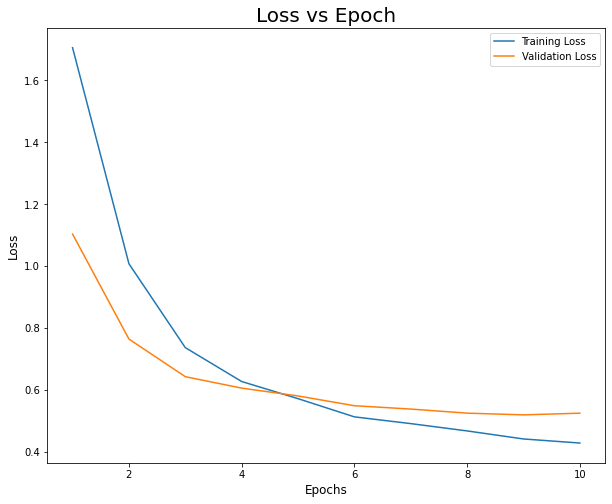

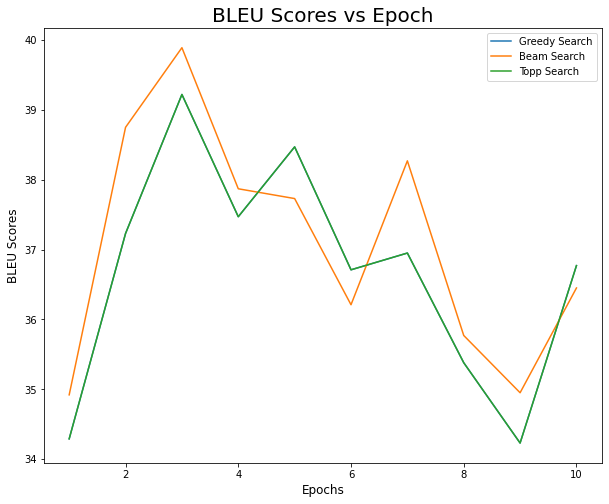

In [39]:
# Loss Chart
train_loss = load_hist['TRAINING_HISTORY']['train_loss']
val_loss = load_hist['TRAINING_HISTORY']['val_loss']
val_BLEU_greedy = load_hist['TRAINING_HISTORY']['val_bleu_greedy']
val_BLEU_beam = load_hist['TRAINING_HISTORY']['val_bleu_beam']
val_BLEU_topp = load_hist['TRAINING_HISTORY']['val_bleu_topp']
x = np.arange(10)+1
plt.figure(figsize=(10,8))
plt.plot(x, train_loss)
plt.plot(x, val_loss)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Epoch', fontsize=20)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
plt.figure(figsize=(10,8))
plt.plot(x, val_BLEU_greedy)
plt.plot(x, val_BLEU_beam)
plt.plot(x, val_BLEU_topp)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('BLEU Scores', fontsize=12)
plt.title('BLEU Scores vs Epoch', fontsize=20)
plt.legend(['Greedy Search', 'Beam Search', 'Topp Search'])
plt.show()

# 4. Evaluation

## Evaluation Function

In [197]:
def calc_bleu(test_loader, model, tokenizer, text_length, beam_size, top_p):
    
    start_time = time.time()
    
    # Generate Predictions
    input_code = []
    actual_text = []
    pred_text_greedy = []
    pred_text_beam = []
    pred_text_topp = []
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            
            labels[labels==-100] = 0
            batch_input_code = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            batch_actual_text = tokenizer.batch_decode(labels, skip_special_tokens=True)
            input_code.extend(batch_input_code)
            actual_text.extend(batch_actual_text)
            
            
            input_ids = input_ids.to(device)
            
            # Greedy Search Generation
            batch_pred_ids_greedy = model.generate(input_ids=input_ids, max_length=text_length).detach().cpu()
            
            # Beam Search with Size = beam_size
            batch_pred_ids_beam = model.generate(input_ids=input_ids, max_length=text_length, num_beams=beam_size, early_stopping=True).detach().cpu()
            
            # Top-p Sampling with probability = top_p
            batch_pred_ids_topp = model.generate(input_ids=input_ids, max_length=text_length, top_p=top_p, top_k=0).detach().cpu()
            
            # Decoding
            batch_pred_text_greedy = tokenizer.batch_decode(batch_pred_ids_greedy, skip_special_tokens=True)
            batch_pred_text_beam = tokenizer.batch_decode(batch_pred_ids_beam, skip_special_tokens=True)
            batch_pred_text_topp = tokenizer.batch_decode(batch_pred_ids_topp, skip_special_tokens=True)
            
            pred_text_greedy.extend(batch_pred_text_greedy)
            pred_text_beam.extend(batch_pred_text_beam)
            pred_text_topp.extend(batch_pred_text_topp)
    
    end_gen_time = time.time() 
    
    print('Text Generation Completed ~')
    
    # Calculate BLEU Score
    num_sample = len(actual_text)
    bleu = datasets.load_metric('sacrebleu')
    
    # Greedy Search BLEU Score
    score_greedy = []
    for i in range(num_sample):
        ref_text = actual_text[i]
        single_pred = pred_text_greedy[i]
        bleu.add_batch(predictions=[single_pred], references=[[ref_text]])
        bleu_score = round(bleu.compute(smooth_method="add-k")['score'],2)
        score_greedy.append(bleu_score)
        
    # Beam Search BLEU Score
    score_beam = []
    for i in range(num_sample):
        ref_text = actual_text[i]
        single_pred = pred_text_beam[i]
        bleu.add_batch(predictions=[single_pred], references=[[ref_text]])
        bleu_score = round(bleu.compute(smooth_method="add-k")['score'],2)
        score_beam.append(bleu_score)
        
    # Top-p search generation BLEU Score
    score_topp = []
    for i in range(num_sample):
        ref_text = actual_text[i]
        single_pred = pred_text_topp[i]
        bleu.add_batch(predictions=[single_pred], references=[[ref_text]])
        bleu_score = round(bleu.compute(smooth_method="add-k")['score'],2)
        score_topp.append(bleu_score)
        
    
    df = pd.DataFrame(np.array([input_code, actual_text, pred_text_greedy, score_greedy, pred_text_beam, score_beam, pred_text_topp, score_topp]).T, 
                      columns=['Input_Code', 'Original_Text', 'Generated_Text_Greedy', 'BLEU_Score_Greedy', 'Generated_Text_Beam', 'BLEU_Score_Beam', 'Generated_Text_Topp', 'BLEU_Score_Topp'])
    
    end_time = time.time()
    
    print('BLEU Score Calculation Completed ~')

    total_time_elapsed = round(end_time-start_time)
    text_generation_time = round(end_gen_time-start_time)
    bleu_calculation_time = round(end_time-end_gen_time)
    avg_generation_time = round(text_generation_time / num_sample, 5)
    avg_bleu_time = round(bleu_calculation_time / num_sample, 5)
    
    print('-' * 70)
    print('Total time taken for running evaluation           : {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Total time taken for text generation              : {:.0f}m {:.0f}s'.format(text_generation_time // 60, text_generation_time % 60))
    print('Total time taken for BLEU score calculations      : {:.0f}m {:.0f}s'.format(bleu_calculation_time // 60, bleu_calculation_time % 60))
    print('Average time taken to generate text 1 sample      : {:.3f}s'.format(avg_generation_time))
    print('Average time taken to calculate BLUE for 1 sample : {:.3f}s'.format(avg_bleu_time))
    print('-' * 70)
    print('Total number of samples generated  :', len(actual_text))
    print('Batch size used in text generation :', test_loader.batch_size)
    
    return df

In [31]:

full_dataset = TOD_Dataset(data_df, tokenizer, MAX_LENGTH)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(len(full_dataset))
print(len(full_loader))

1030
17


## Run Evaluation on Full Dataset

In [196]:
CALLBACK_PATH_TOPP

'D:\\Personal\\Education\\NUS-ISS Mtech IS\\Course Materials\\4. Practical Language Processing (PLP)\\0. PLP Project\\Code\\NLG\\model_state\\t5-small_lr4_FINE_TUNING_TOPP.pt'

In [198]:
# Load Model
MODEL_NAME = 't5-small'
EVAL_MODEL_LOAD_PATH = CALLBACK_PATH_TOPP
eval_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

load_dict = torch.load(EVAL_MODEL_LOAD_PATH)
eval_model.load_state_dict(load_dict)

# Generate Text and Calculate BLEU
eval_df = calc_bleu(full_loader, eval_model, tokenizer, MAX_LENGTH, 4, 0.8)

Text Generation Completed ~
BLEU Score Calculation Completed ~
----------------------------------------------------------------------
Total time taken for running evaluation           : 1m 36s
Total time taken for text generation              : 1m 17s
Total time taken for BLEU score calculations      : 0m 19s
Average time taken to generate text 1 sample      : 0.075s
Average time taken to calculate BLUE for 1 sample : 0.018s
----------------------------------------------------------------------
Total number of samples generated  : 1030
Batch size used in text generation : 64


## BLEU Score Statistics

In [33]:
eval_df

,Input_Code,Original_Text,Generated_Text_Greedy,BLEU_Score_Greedy,Generated_Text_Beam,BLEU_Score_Beam,Generated_Text_Topp,BLEU_Score_Topp
0,MOVIE_RECOMMEND REQUEST ( genre =? ; directed_...,"Do you have any preference on the movie genre,...","Do you have any movie genre, director or actor...",34.54,"Do you have any movie genre, director or actor...",34.54,"Do you have any movie genre, director or actor...",34.54
1,MOVIE_RECOMMEND REQUEST ( genre =? ; directed_...,"Any preference on the genre, directors or acto...","Do you have any movie genre, director or actor...",11.2,"Do you have any movie genre, director or actor...",11.2,"Do you have any movie genre, director or actor...",11.2
2,MOVIE_RECOMMEND REQUEST ( genre =? ; directed_...,What kind of movie do you like? Any movie genr...,"Do you have any movie genre, director or actor...",13.51,"Do you have any movie genre, director or actor...",13.51,"Do you have any movie genre, director or actor...",13.51
3,MOVIE_RECOMMEND REQUEST ( genre =? ; directed_...,"Any movie genre, directors or actors you have ...","Do you have any movie genre, director or actor...",22.38,"Do you have any movie genre, director or actor...",22.38,"Do you have any movie genre, director or actor...",22.38
4,MOVIE_RECOMMEND REQUEST ( genre =? ; directed_...,What type of movie do you like? Any movie genr...,"Do you have any movie genre, director or actor...",36.73,"Do you have any movie genre, director or actor...",36.73,"Do you have any movie genre, director or actor...",36.73
...,...,...,...,...,...,...,...,...
1025,MOVIE_SENTIMENT GOODBYE,Have a nice day,Have a good day.,37.61,Have a good day.,37.61,Have a good day.,37.61
1026,MOVIE_SENTIMENT GOODBYE,Have a nice day!,Have a good day.,37.61,Have a good day.,37.61,Have a good day.,37.61
1027,MOVIE_SENTIMENT GOODBYE,You're welcome. Enjoy the movie.,Have a good day.,16.11,Have a good day.,16.11,Have a good day.,16.11
1028,MOVIE_SENTIMENT GOODBYE,Have a good day.,Have a good day.,100.0,Have a good day.,100.0,Have a good day.,100.0


## Save Evaluation Results to File

In [100]:
eval_result_savepath = os.path.join(basedir, 'eval_result\\' + MODEL_NAME + '_eval.csv')

eval_df.to_csv(eval_result_savepath)

## Text Generation Examples

### Sample 1

In [200]:
sample_input_ids

tensor([[ 7109,   553,  5091,   834,  4386,  6657,   329, 14920,  4486,  6058,
           476,   834,   134, 19356,  8360,  2365,    41,  5349,  3274, 14210,
             3,    61,     1,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]], device='cuda:0')

In [199]:
sample_control_code = 'MOVIE_RECOMMEND NOTIFY_SEARCHING ( genre = romance )'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.17
Total generation time for greedy search :  0.05
Total generation time for beam search   :  0.08
Total generation time for topp search   :  0.05
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_RECOMMEND NOTIFY_SEARCHING ( genre = romance )
Greedy Search Generation : Looking for romance movies
Beam Search Generation   : Looking for some romance movies
Topp Search Generation   : Looking for romance movies


### Sample 2

In [132]:
sample_control_code = 'MOVIE_SENTIMENT NOTIFY_FAILURE ( title = SomeMovieName )'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.53
Total generation time for greedy search :  0.16
Total generation time for beam search   :  0.21
Total generation time for topp search   :  0.16
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_SENTIMENT NOTIFY_FAILURE ( title = SomeMovieName )
Greedy Search Generation : I am sorry but I couldn't find any public comments about the movie named SomeMovieName
Beam Search Generation   : I am sorry but I couldn't find any public comments about the movie named SomeMovieName
Topp Search Generation   : I am sorry but I couldn't find any public comments about the movie named SomeMovieName


### Sample 3

In [206]:
sample_control_code = 'MOVIE_RECOMMEND NOTIFY_SUCCESS ( genre = crime ; director = Someone Name ; actor = Another Name )'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.39
Total generation time for greedy search :  0.12
Total generation time for beam search   :  0.15
Total generation time for topp search   :  0.12
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_RECOMMEND NOTIFY_SUCCESS ( genre = crime ; director = Someone Name ; actor = Another Name )
Greedy Search Generation : Below are some crime movies directed by Someone Name and acted by Another Name
Beam Search Generation   : Below are some crime movies directed by Someone Name and acted by Another Name
Topp Search Generation   : Below are some crime movies directed by Someone Name and acted by Another Name


### Sample 4

In [137]:
sample_control_code = 'MOVIE_SENTIMENT NOTIFY_SUCCESS ( title = Some Movie )'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.49
Total generation time for greedy search :  0.15
Total generation time for beam search   :  0.2
Total generation time for topp search   :  0.14
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_SENTIMENT NOTIFY_SUCCESS ( title = Some Movie )
Greedy Search Generation : Below is a summary of what people have been discussing about the movie named Some Movie
Beam Search Generation   : Below is a summary of what people have been talking about the movie named Some Movie
Topp Search Generation   : Below is a summary of what people have been discussing about the movie named Some Movie


### Sample 5

In [138]:
sample_control_code = 'MOVIE_RECOMMEND REQ_MORE'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.31
Total generation time for greedy search :  0.1
Total generation time for beam search   :  0.12
Total generation time for topp search   :  0.1
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_RECOMMEND REQ_MORE
Greedy Search Generation : Is there anything else I can help you with?
Beam Search Generation   : Can I help with anything else?
Topp Search Generation   : Is there anything else I can help you with?


### Sample 6

In [139]:
sample_control_code = 'MOVIE_SENTIMENT GOODBYE'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.2
Total generation time for greedy search :  0.06
Total generation time for beam search   :  0.08
Total generation time for topp search   :  0.06
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_SENTIMENT GOODBYE
Greedy Search Generation : Have a good day.
Beam Search Generation   : Have a good day.
Topp Search Generation   : Have a good day.


### Sample 7

In [140]:
sample_control_code = 'MOVIE_SENTIMENT REQUEST ( title = ? )'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.56
Total generation time for greedy search :  0.17
Total generation time for beam search   :  0.21
Total generation time for topp search   :  0.17
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_SENTIMENT REQUEST ( title = ? )
Greedy Search Generation : Do you have a particular movie title in mind you want to know what people are talking about it?
Beam Search Generation   : Do you have a particular movie title in mind you want the sentiment analysis on?
Topp Search Generation   : Do you have a particular movie title in mind you want to know what people are talking about it?


In [141]:
sample_control_code = 'MOVIE_RECOMMEND REQUEST ( genre = ? ; directed_by = ? ; starring = ? )'
sample_input_ids = tokenizer.encode(sample_control_code, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors = 'pt')

sample_beam_size = 5
sample_topp = 0.8
sample_input_ids = sample_input_ids.to(device)

# Generation by Greedy Search
time_0 = time.time()
sample_generated_ids_greedy = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH).detach().cpu()
sample_generated_text_greedy = tokenizer.decode(sample_generated_ids_greedy[0], skip_special_tokens=True)

# Generation by Beam Search
time_1 = time.time()
sample_generated_ids_beam = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, num_beams=sample_beam_size, early_stopping=True).detach().cpu()
sample_generated_text_beam = tokenizer.decode(sample_generated_ids_beam[0], skip_special_tokens=True)

# Generation by Top-p Search
time_2 = time.time()
sample_generated_ids_topp = eval_model.generate(input_ids=sample_input_ids, max_length=MAX_LENGTH, top_p=sample_topp, top_k=0).detach().cpu()
sample_generated_text_topp = tokenizer.decode(sample_generated_ids_topp[0], skip_special_tokens=True)

time_3 = time.time()

print('Total processing time                   : ', round(time_3 - time_0,2))
print('Total generation time for greedy search : ', round(time_1 - time_0,2))
print('Total generation time for beam search   : ', round(time_2 - time_1,2))
print('Total generation time for topp search   : ', round(time_3 - time_2,2))

print('-' * 70)
print('Control Code (Input)     :', sample_control_code)
print('Greedy Search Generation :', sample_generated_text_greedy)
print('Beam Search Generation   :', sample_generated_text_beam) 
print('Topp Search Generation   :', sample_generated_text_topp)

Total processing time                   :  0.4
Total generation time for greedy search :  0.11
Total generation time for beam search   :  0.18
Total generation time for topp search   :  0.11
----------------------------------------------------------------------
Control Code (Input)     : MOVIE_RECOMMEND REQUEST ( genre = ? ; directed_by = ? ; starring = ? )
Greedy Search Generation : Do you have any movie genre, director or actor you prefer?
Beam Search Generation   : Do you have any movie genre, director or actor you prefer?
Topp Search Generation   : Do you have any movie genre, director or actor you prefer?


# 5. Model Serialization

In [130]:
# Load Model
MODEL_NAME = 't5-small'
DEPLOY_MODEL_LOAD_PATH = CALLBACK_PATH_TOPP
deploy_model_gpu = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)
deploy_model_cpu = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

load_dict = torch.load(DEPLOY_MODEL_LOAD_PATH)
deploy_model_gpu.load_state_dict(load_dict)
deploy_model_cpu.load_state_dict(load_dict)

# Load Tokenizer
deploy_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [135]:
# Create Input Samples
random.seed(seed)
deploy_sample_idx = random.randint(0, len(df))
deploy_sample_text = df['Code'].tolist()[deploy_sample_idx]

# Tokenized sample inputs
deploy_sample_tokenized = tokenizer(deploy_sample_text,
                                    padding='max_length',
                                    max_length=MAX_LENGTH,
                                    truncation=True, 
                                    return_attention_mask = True, 
                                    return_tensors = 'pt')
deploy_sample_input_ids = deploy_sample_tokenized['input_ids']
deploy_sample_attn_mask = deploy_sample_tokenized['attention_mask']
deploy_sample_jit_input_gpu = (deploy_sample_input_ids.to(device), deploy_sample_attn_mask.to(device))
deploy_sample_jit_input_cpu = (deploy_sample_input_ids, deploy_sample_attn_mask)

print('Sample text input     :', deploy_sample_text)
print('Sample input ids      :', deploy_sample_input_ids, '|', deploy_sample_input_ids.size())
print('Sample attention mask :', deploy_sample_attn_mask, '|', deploy_sample_attn_mask.size())


Sample text input     : MOVIE_RECOMMEND REQ_MORE
Sample input ids      : tensor([[ 7109,   553,  5091,   834,  4386,  6657,   329, 14920,  4083,  2247,
           834,   329, 20888,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]) | torch.Size([1, 64])
Sample attention mask : tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) | torch.Size([1, 64])


In [195]:
# Save GPU model using TorchScript - Trace
deploy_model_gpu.eval()
deploy_model_gpu.to(device)
start = time.time()
# module_output  = torch.jit.trace_module(deploy_model_gpu.generate, deploy_sample_jit_input_gpu)

output = deploy_model_gpu.generate(input_ids=deploy_sample_input_ids.to(device))
print(round(time.time()-start,5))
print(tokenizer.decode(output[0], skip_special_tokens=True))

0.08779
Is there anything else I can help you with?
